# Show mesh

In this notebook it is possible to explore the 3D hippocampus segmented with Fastsurfer, comparing the segmentation result to the ones of FreeSurfer.

In [1]:
from ipywidgets import widgets
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

import numpy as np
import nibabel as nib
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

from nilearn import plotting
from monai.transforms import (
	CropForeground,
    Resize, 
    SpatialPad,
    Compose,
    EnsureChannelFirst,
    Spacing,
    LoadImage,
    HistogramNormalize,
    NormalizeIntensity,
    RandScaleIntensity,
    RandShiftIntensity,
    Rotate
)

- Transformations

In [2]:
size = 40

transform = Compose([
    LoadImage(reader='NibabelReader'),
    EnsureChannelFirst(),
    Spacing(
        pixdim=(1.0, 1.0, 1.0),
        mode='bilinear',
        align_corners=True,
        scale_extent=True
    ),
    CropForeground(select_fn=(lambda x: x > 0), allow_smaller=True),
    SpatialPad(spatial_size=(size, size, size), mode='minimum'),
    Resize(
            spatial_size=(size, size, size),
            size_mode='all',
            mode='bilinear',
            align_corners=True,
            anti_aliasing=True
    ),
])


transform_fast = Compose([
    LoadImage(reader='NibabelReader'),
    HistogramNormalize(),
    #NormalizeIntensity(nonzero=True, channel_wise=True),
	RandScaleIntensity(factors=0.1, prob=1.0),
	RandShiftIntensity(offsets=0.1, prob=1.0),
    Rotate(angle=(60 * np.pi) / 180, padding_mode='zeros', align_corners=True)
])

- Freesurfer hippocampi

In [3]:
hippo_left_freesurfer = transform('../data/freesurfers_undersampled/OAS31268_MR_d0132/mri/posterior_Left-Hippocampus.mgz').numpy()
hippo_right_freesurfer = transform('../data/freesurfers_undersampled/OAS31268_MR_d0132/mri/posterior_Right-Hippocampus.mgz').numpy()

- Fastsurfer hippocampi

In [10]:
hippo_left_fastsurfer = nib.load('../data/segmented/OAS30004_MR_d1101/mri/hippocampus_left.nii.gz').get_fdata()
hippo_right_fastsurfer = nib.load('../data/segmented/OAS30004_MR_d1101/mri/hippocampus_right.nii.gz').get_fdata()

- Concatenation

In [5]:
hippo_freesurfer = np.concatenate((hippo_left_freesurfer[0, :, :, :], hippo_right_freesurfer[0, :, :, :]))
hippo_fastsurfer = np.concatenate((hippo_left_fastsurfer[0, :, :, :], hippo_right_fastsurfer[0, :, :, :]))

## 2D Visualizations

- Freesurfer hippocampus

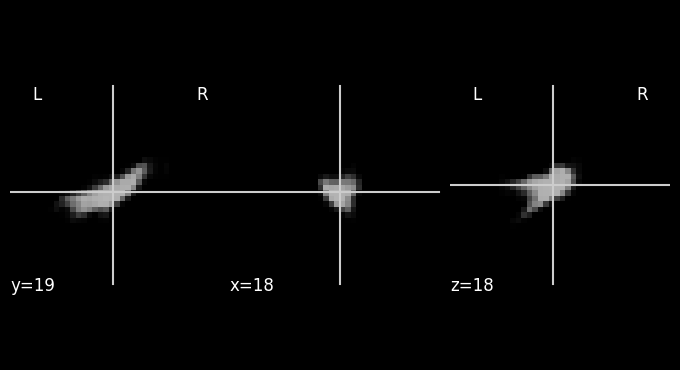

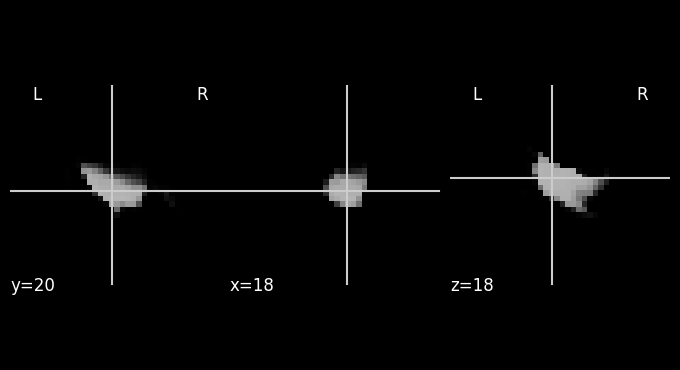

In [6]:
plotting.plot_anat(nib.Nifti1Image(hippo_left_freesurfer[0, :, :, :], np.identity(4)));
plotting.plot_anat(nib.Nifti1Image(hippo_right_freesurfer[0, :, :, :], np.identity(4)));

- Fastsurfer hippocampus

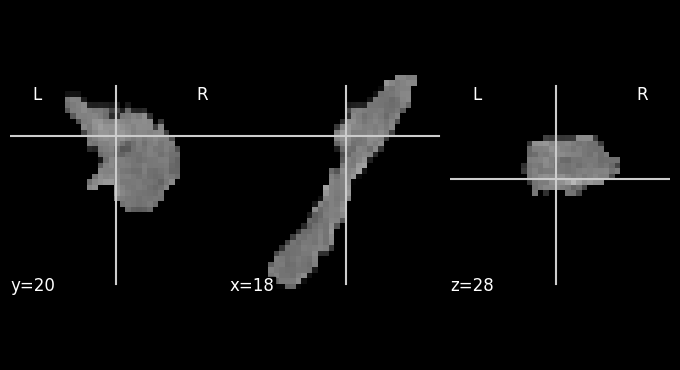

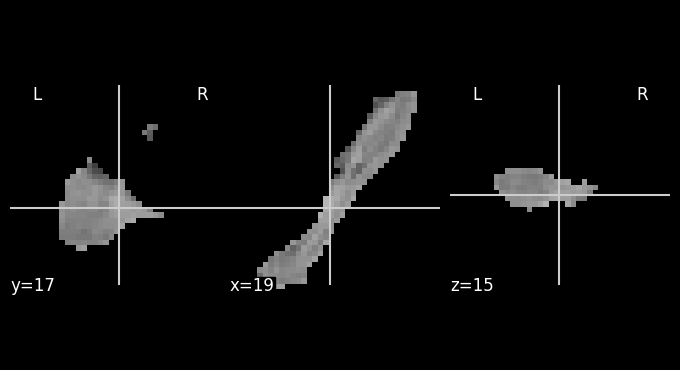

In [11]:
plotting.plot_anat(nib.Nifti1Image(hippo_left_fastsurfer[0, :, :, :], np.identity(4)));
plotting.plot_anat(nib.Nifti1Image(hippo_right_fastsurfer[0, :, :, :], np.identity(4)));

- Interactive 3D visualization

In [ ]:
@widgets.interact_manual(
    hippo_type=['Freesurfer', 'Fastsurfer'],
    direction=['left', 'right', 'both']
)
def plot_3d_plotly_shape(hippo_type, direction, show_mesh=True, crop=True, grid=True):
  import plotly.graph_objects as go

  if direction == 'both':
    hippo = hippo_freesurfer if hippo_type == 'Freesurfer' else hippo_fastsurfer

  if direction == 'left':
    hippo = hippo_left_freesurfer[0, :, :, :] if hippo_type == 'Freesurfer' else hippo_left_fastsurfer[0, :, :, :]

  if direction == 'right':
    hippo = hippo_right_freesurfer[0, :, :, :] if hippo_type == 'Freesurfer' else hippo_right_fastsurfer[0, :, :, :]

  print(hippo.shape)
  vert_p, faces_p, _, _ = measure.marching_cubes(hippo, 0, spacing=(1, 1, 1))

  fig = go.Figure(data=[go.Mesh3d(
        x=vert_p[:, 0],
        y=vert_p[:, 1],
        z=vert_p[:, 2],
        # i, j and k give the vertices of triangles
        # here we represent the 4 triangles of the tetrahedron surface
        i=faces_p[:, 0],
        j=faces_p[:, 1],
        k=faces_p[:, 2],
        name='y',
        showscale=True
    )]
  )

  if show_mesh:
    #plot surface triangulation
    tri_vertices = vert_p[faces_p]
    Xe = []
    Ye = []
    Ze = []
    
    for T in tri_vertices:
      Xe += [T[k%3][0] for k in range(4)] + [ None]
      Ye += [T[k%3][1] for k in range(4)] + [ None]
      Ze += [T[k%3][2] for k in range(4)] + [ None]
       
    fig.add_trace(go.Scatter3d(
                     x=Xe,
                     y=Ye,
                     z=Ze,
                     mode='lines',
                     name='',
                     line=dict(color= 'rgb(140,140,140)', width=0.5)))
  if crop:
    scale_min = np.min(vert_p, axis=0)
    scale_max = np.max(vert_p, axis=0)
      
  fig.update_layout(
    scene = dict(aspectratio=dict(x=1, y=1, z=1),
        xaxis = dict(range=[scale_min[0], scale_max[0]], visible=grid),
        yaxis = dict(range=[scale_min[1], scale_max[1]], visible=grid),
        zaxis = dict(range=[scale_min[2], scale_max[2]], visible=grid),) 
    )

  fig.show()

interactive(children=(Dropdown(description='hippo_type', options=('Freesurfer', 'Fastsurfer'), value='Freesurf…